Searching for galaxy images near this sky position...
Found 165 objects with imaging!
Selected object: RA=185.761113, DEC=15.859698


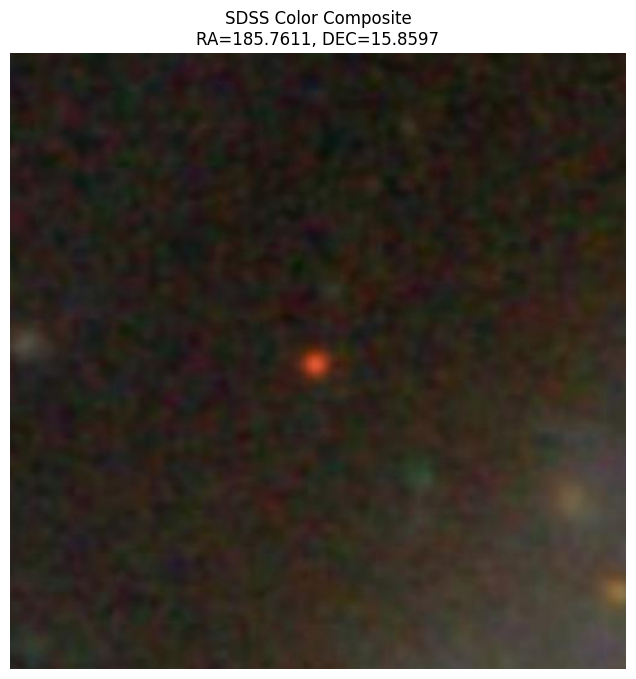

=== Done! ===


In [5]:
from astroquery.sdss import SDSS

from astropy import coordinates as coords

import astropy.units as u

import matplotlib.pyplot as plt

import numpy as np

from PIL import Image

import requests

from io import BytesIO



RA = 185.7292  # Right Ascension (in degrees)

DEC = 15.8219   # Declination (in degrees)



SEARCH_RADIUS = 0.05



# === Step 2: Tell the computer where to look in the sky ===

position = coords.SkyCoord(ra=RA, dec=DEC, unit='deg')

print("Searching for galaxy images near this sky position...")



# === Step 3: Ask SDSS for any galaxy images at this position ===

try:

    results = SDSS.query_region(position, radius=SEARCH_RADIUS * u.deg, photoobj_fields=['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'objid', 'type', 'petroMag_r', 'petroR50_r', 'petroR90_r'])

except Exception as e:

    print("That coordinate didn't work!")



# If nothing is found, stop

if results is None or len(results) == 0:

    print("No galaxy images found here.")

    exit()



print(f"Found {len(results)} objects with imaging!")



# === Step 4: Get the first available galaxy (type = 3 means galaxy) ===

galaxy_objects = results[results['type'] == 3]  # Filter for galaxies only

if len(galaxy_objects) == 0:

    print("No galaxies found in the results, using first object instead.")

    first = results[0]

else:

    first = galaxy_objects[0]



print(f"Selected object: RA={first['ra']:.6f}, DEC={first['dec']:.6f}")



# === Step 5: Download the composite image ===

print("Downloading color composite image...")



# Create URL for SDSS color image

ra_center = first['ra']

dec_center = first['dec']

scale = 0.1  # arcsec per pixel

width = 512  # in pixels

height = 512 # in pixels



img_url = f"https://skyserver.sdss.org/dr17/SkyServerWS/ImgCutout/getjpeg?ra={ra_center}&dec={dec_center}&scale={scale}&width={width}&height={height}"



# === Step 6: Show the galaxy! ===

try:

    response = requests.get(img_url)

    if response.status_code == 200:

        img = Image.open(BytesIO(response.content))

        plt.figure(figsize=(8, 8))

        plt.imshow(img)

        plt.title(f'SDSS Color Composite\nRA={first["ra"]:.4f}, DEC={first["dec"]:.4f}')

        plt.axis('off')

        plt.show()

    else:

        print("Color image download failed")

        

except Exception as e:

    print(f"Color image failed: {e}")



print("=== Done! ===")

Querying galaxy at RA=185.7292, DEC=15.8219...


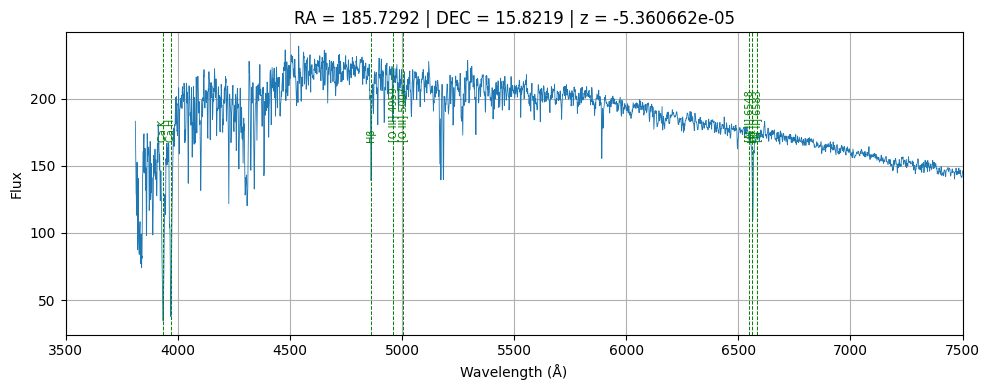

In [13]:
from astroquery.sdss import SDSS
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

# ==== Galaxy Info (choose one) ====
galaxy = {
    "name": "?",      # Optional: You can set to "?" if you want to auto-resolve it
    "ra": 185.7292,         # Right Ascension in degrees
    "dec": 15.8219           # Declination in degrees
}

SEARCH_RADIUS = 0.05  # degrees

# ==== Common Spectral Lines (rest-frame, in Ångströms) ====
spectral_lines = {
    "Ca K": 3934.78,
    "Ca H": 3969.59,
    "Hβ": 4861.33,
    "[O III] 4959": 4958.91,
    "[O III] 5007": 5006.84,
    "[N II] 6548": 6548.05,
    "Hα": 6562.80,
    "[N II] 6583": 6583.45,
}

# ==== Optional: Get galaxy name from SIMBAD if not provided ====
def get_object_name(ra, dec):
    pos = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs')
    try:
        result = Simbad.query_region(pos, radius='5s')
        if result is not None and len(result) > 0:
            return result[0]['MAIN_ID'].decode('utf-8').replace(' ', '_')
    except Exception:
        pass
    return None

# ==== Main Process ====
print(f"Querying galaxy at RA={galaxy['ra']}, DEC={galaxy['dec']}...")

pos = SkyCoord(ra=galaxy['ra']*u.deg, dec=galaxy['dec']*u.deg)

results = SDSS.query_region(
    pos,
    radius=SEARCH_RADIUS * u.deg,
    spectro=True,
    specobj_fields=['plate', 'mjd', 'fiberID', 'z']
)

if results is None or len(results) == 0:
    print("No spectra found for this galaxy.")
else:
    row = results[0]
    try:
        spectrum = SDSS.get_spectra(plate=int(row['plate']),
                                    mjd=int(row['mjd']),
                                    fiberID=int(row['fiberID']))[0]

        hdu = spectrum[1]
        flux = hdu.data['flux']
        loglam = hdu.data['loglam']
        wavelength = 10**loglam

        z = float(row['z'])
        name = get_object_name(galaxy['ra'], galaxy['dec']) or galaxy['name']
        safe_name = name.lower().replace(' ', '_')

        # === Plot the Spectrum ===
        plt.figure(figsize=(10, 4))
        plt.plot(wavelength, flux, lw=0.6)
        plt.xlim([3500, 7500])
        plt.xlabel("Wavelength (Å)")
        plt.ylabel("Flux")
        plt.title(f"RA = {RA} | DEC = {DEC} | z = {z}")
        plt.grid(True)

        # === Add Spectral Line Labels ===
        for label, lam_rest in spectral_lines.items():
            lam_obs = lam_rest * (1 + z)
            if wavelength[0] < lam_obs < wavelength[-1]:
                plt.axvline(lam_obs, color='green', linestyle='--', linewidth=0.7)
                plt.text(lam_obs, max(flux)*0.7, label, rotation=90,
                         fontsize=7, color='green', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error retrieving or plotting spectrum: {e}")


In [32]:
c = 299792.458  # km/s

if z < 0.1:
    velocity = abs(z * c)
else:
    velocity = abs(c * ((1 + z)**2 - 1) / ((1 + z)**2 + 1))

print(f"Recessional velocity = {velocity:.2f} km/s")


Recessional velocity = 16.07 km/s


In [31]:
H0 = 72 # km/s/Mpc
H = H0 * (1 + z)  # Hubble parameter at redshift z
D = ((velocity / H)*u.Mpc).to(u.km) # in Mpc
print(f"Distance = {D:.2e}".replace('e+', ' × 10^'))

Distance = 6.89 × 10^18 km


In [34]:
R50 = first['petroR50_r']  # Petrosian radius at 50% light in r-band
R90 = first['petroR90_r']  # Petrosian radius at 90% light in r-band
v = R90 / R50  # Calculate the ratio of R90 to R50
print (v)
try:
    if v < 2.2:
        classification = "Late-type spiral or irregular galaxy (disk-dominated)"
    elif 2.2 <= v < 2.6:
        classification = "Intermediate spiral galaxy (disk + bulge)"
    else:
        classification = "Elliptical or bulge-dominated spiral galaxy"

    print(f"Galaxy type: {classification}")

except Exception as e:  
    print(f"Category unknown: {e}")

1.314728776011418
Galaxy type: Late-type spiral or irregular galaxy (disk-dominated)
